In [86]:
#Install needed libraries
#!pip install -r requirements.txt


In [3]:
#Load required libraries
import json
import langchain
import numpy as np
import openai
import os
import pandas as pd
import pickle
import psutil
import requests
import time
import torch
import autogen
from os import listdir
from os.path import isfile, join
from os.path import join
from langchain_openai import AzureOpenAIEmbeddings
from sentence_transformers import SentenceTransformer
from bert_score import score
from langchain import OpenAI
from langchain.chat_models import ChatOpenAI
from langchain.vectorstores import FAISS
from langchain.chains import RetrievalQA
from langchain.chains import RetrievalQAWithSourcesChain
from langchain.docstore import InMemoryDocstore  
from langchain.document_loaders import PyPDFLoader
from langchain.embeddings import HuggingFaceBgeEmbeddings
from langchain.embeddings.sentence_transformer import SentenceTransformerEmbeddings
from langchain.prompts import PromptTemplate
from langchain.retrievers import ContextualCompressionRetriever
from langchain.retrievers import ParentDocumentRetriever, BM25Retriever, EnsembleRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain.storage import InMemoryStore
from langchain.text_splitter import CharacterTextSplitter
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.vectorstores import FAISS
from langchain.embeddings import OpenAIEmbeddings
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.chat_models import AzureChatOpenAI
from langchain.embeddings.huggingface import HuggingFaceEmbeddings
#from langchain_community.vectorstores import Chroma
from langchain_chroma import Chroma
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
import warnings
import pinecone

/opt/conda/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.10/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
2024-08-12 01:04:51.100950: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# Laad model configs

ModelConfig = autogen.config_list_from_json(
            "OAI_CONFIG_LIST.json",
            filter_dict={"model": [""]}
        )

ModelConfigEmbedding = autogen.config_list_from_json(
            "OAI_CONFIG_LIST.json",
            filter_dict={"model": ["adadeployment"]}
        )

In [ ]:
#Use GPT4 as LLM (hosted on Azure OpenAI)
llm = AzureChatOpenAI(
            azure_endpoint=ModelConfig[0][""],
            api_version=ModelConfig[0]["api_version"],
            deployment_name="",
            api_key=ModelConfig[0][""],
            openai_api_type="azure"
        )


/opt/conda/lib/python3.10/site-packages/langchain_core/_api/deprecation.py:119: LangChainDeprecationWarning: The class `AzureChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 0.3.0. An updated version of the class exists in the langchain-openai package and should be used instead. To use it run `pip install -U langchain-openai` and import as `from langchain_openai import AzureChatOpenAI`.
  warn_deprecated(


In [5]:
#initialise embedding model. ADA-002, hosted on AzureOPenAI

from langchain_openai import AzureOpenAIEmbeddings
 
embedding_function = AzureOpenAIEmbeddings(
    azure_endpoint=ModelConfigEmbedding[0]["base_url"],
    azure_deployment='adadeployment',
    api_key=ModelConfigEmbedding[0]["api_key"],
    openai_api_version=ModelConfigEmbedding[0]["api_version"]
)

In [ ]:
#Load pdf from the folder. I've chosen a document about an awards program
filepath = r"./Data/"
onlyfiles = [f for f in listdir(filepath)]

pdf_list = []

for file in onlyfiles:
    if not file.startswith('.'): #this make sure not to cause error fur to .ipynb_checkpoints
        loader = PyPDFLoader(join(filepath,file))
        pdf_list.extend(loader.load())
print(len(pdf_list)) #shows number of pages in PDF

25


# Cost Evaluation


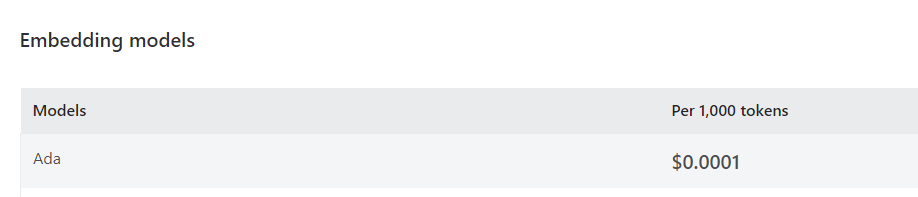


In [24]:
#Evaluate cost of document embediing 
import tiktoken 

enc = tiktoken.encoding_for_model("text-embedding-ada-002")  
 
total_tokens = sum(len(enc.encode(text.page_content)) for text in pdf_list) 
 
cost_per_1k_tokens = 0.0001 
 
print('Total tokens:', total_tokens) 
print('Cost:', cost_per_1k_tokens * total_tokens/1000) 


#total cost of embedding is shown below

Total tokens: 10801
Cost: 0.0010801


In [27]:
''' #this is backup embedding model
#define embedding model
from langchain.embeddings import HuggingFaceBgeEmbeddings
model_name = "BAAI/bge-large-en-v1.5"
model_kwargs = {'device': 'cpu'}
encode_kwargs = {'normalize_embeddings': True}

embedding_function = HuggingFaceBgeEmbeddings(
    model_name=model_name,
    model_kwargs=model_kwargs,
    encode_kwargs=encode_kwargs,  
)
embedding_function
'''


/opt/conda/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


HuggingFaceBgeEmbeddings(client=SentenceTransformer(
  (0): Transformer({'max_seq_length': 512, 'do_lower_case': True}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 1024, 'pooling_mode_cls_token': True, 'pooling_mode_mean_tokens': False, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False, 'pooling_mode_weightedmean_tokens': False, 'pooling_mode_lasttoken': False, 'include_prompt': True})
  (2): Normalize()
), model_name='BAAI/bge-large-en-v1.5', cache_folder=None, model_kwargs={'device': 'cpu'}, encode_kwargs={'normalize_embeddings': True}, query_instruction='Represent this question for searching relevant passages: ', embed_instruction='')

# Data preparation: splitting and embedding into vector DB


In [31]:
# # Split documetns 
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=100)

splits = text_splitter.split_documents(pdf_list)


In [32]:

# Creating a Vector DB
vectorstore = FAISS.from_documents(splits, embedding_function)

In [33]:
#save locally 
vectorstore.save_local("./VectorDB/")

# Prepare retrievals and generate reponses for questions saved in the Excel File Q&A.xlsx


In [94]:
#setup five  of retrievals for further testing 

faiss_retriever = vectorstore.as_retriever(search_kwargs={"k": 5},text_splitter_class=RecursiveCharacterTextSplitter())

compressor = LLMChainExtractor.from_llm(llm)
compression_retriever = ContextualCompressionRetriever(base_compressor=compressor, base_retriever=faiss_retriever)

bm25_retriever = BM25Retriever.from_documents(splits,text_splitter_class=RecursiveCharacterTextSplitter)

from langchain.retrievers.multi_query import MultiQueryRetriever
MultiQueryretriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(), llm=llm
)

ensemble_retriever = EnsembleRetriever(retrievers=[MultiQueryretriever, bm25_retriever], weights=[0.6, 0.4])



In [95]:
# Define a chain to retive response based on RAG data. Function is defined to make it easier to test multiple retrievers
def chain_response(retriever_choice, var_prompt,var_Question):
    start_time = time.time()
    chain = RetrievalQAWithSourcesChain.from_llm(llm=llm, retriever=retriever_choice,return_source_documents=True,)
    chain_time = time.time() - start_time
    print(f"Time taken for retrieval and generation chain: {chain_time:.2f} seconds")

    # Question
    start_time = time.time()

    Prompt = var_prompt
    #response = chain({"question": DefaultPromptNew}, return_only_outputs=True)
    Question = var_Question
    langchain.debug=False
    MainPrompt = f"{Prompt}: {Question}"
    response = chain({"question": MainPrompt}, return_only_outputs=True)
    question_time = time.time() - start_time
    print(f"Time taken to invoke question: {question_time:.2f} seconds")
    #print("Response:", response)
    return response;

In [ ]:
#Read from files - where I saved 6 questions about the file content
Data= pd.read_excel("Q&A.xlsx",sheet_name="Sheet2")

Data['faiss_response_CosSim']=0
Data['compression_response_CosSim']=0
Data['bm25_response_CosSim']=0
Data['MultiQuery_response_CosSim']=0
Data['ensemble_response_CosSim']=0
Data #check file content

,Rank,Question,Difficulty,Context,Answer,Page Number,faiss_response_CosSim,compression_response_CosSim,bm25_response_CosSim,MultiQuery_response_CosSim,ensemble_response_CosSim
0,1,What is a definition of statement period?,Easy,Statement Period means the time period covered...,Statement Period means the time period covered...,page 23,0,0,0,0,0
1,2,What are types of awards available?,Easy,If a Member is a member of a participating Air...,"Airline/Travel Rewards, Awards eShop, Cash Bac...",13-14,0,0,0,0,0
2,3,What are exception from eligible transactions?,Easy,Awards Points accumulate to a Card Account wh...,Payments through the BPAY Electronic Payments...,page 5,0,0,0,0,0
3,4,What is the cap on Bonus Points for 'Smart Awa...,Medium,Points Boost: 2 Bonus Points up to a maximum \...,The cap on Bonus Points for 'Smart Awards' car...,7,0,0,0,0,0
4,5,How long does it take to process points conver...,Medium,Points will normally be available in the Membe...,Points will normally be available in the Membe...,14,0,0,0,0,0
5,6,What is the time limit for redeeming or transf...,Hard,Provided we don’t have the right to suspend or...,you will have 90 days to redeem your remaining...,18,0,0,0,0,0
6,7,How much prior written notice is required for ...,Hard,If we make a change which we reasonably consid...,20 days’ prior written notice,19,0,0,0,0,0


In [97]:
from sklearn.metrics.pairwise import cosine_similarity

#define function to calculate consine similarity
def CosineSimilarity(InputQuery,OutputQuery,embedding_function):
    query_embedding = embedding_function.embed_documents([InputQuery])
    #print("query_embedding: ", query_embedding)
    response_embedding = embedding_function.embed_documents([OutputQuery])
    #print("response_embedding: ", response_embedding)
    similarity_score = cosine_similarity(query_embedding, response_embedding)
    return similarity_score[0][0]

In [98]:
#cycle through questions and record responds from each of retrivers. Use multiple retrievals for future evaluation which one work the best
var_prompt="You are bank customer service representative. Answer the question of the customer in the professional, clear manner."



for index, row in Data.iterrows():

    
    var_Question=row['Question']
    var_anser=row['Answer']
    faiss_response=chain_response(faiss_retriever,var_prompt,var_Question)
    Data.loc[index,'faiss_response']=faiss_response.get('answer')
    Data.loc[index,'faiss_response_CosSim']=CosineSimilarity(var_anser,faiss_response.get('answer'),embedding_function)

    #compression
    compression_response=chain_response(compression_retriever,var_prompt,var_Question)
    Data.loc[index,'compression_response']=compression_response.get('answer')
    Data.loc[index,'compression_response_CosSim']=CosineSimilarity(var_anser,compression_response.get('answer'),embedding_function)
    
    #bm25
    bm25_response=chain_response(bm25_retriever,var_prompt,var_Question)
    Data.loc[index,'bm25_response']=bm25_response.get('answer')
    Data.loc[index,'bm25_response_CosSim']=CosineSimilarity(var_anser,bm25_response.get('answer'),embedding_function)
    
    #multiqury 
    MultiQuery_response=chain_response(MultiQueryretriever,var_prompt,var_Question)
    Data.loc[index,'MultiQuery_response']=MultiQuery_response.get('answer')
    Data.loc[index,'MultiQuery_response_CosSim']=CosineSimilarity(var_anser,MultiQuery_response.get('answer'),embedding_function)
    
    #ensemble 
    ensemble_response=chain_response(ensemble_retriever,var_prompt,var_Question)
    Data.loc[index,'ensemble_response']=ensemble_response.get('answer')
    Data.loc[index,'ensemble_response_CosSim']=CosineSimilarity(var_anser,ensemble_response.get('answer'),embedding_function)


#save results to csv file for fututre reference. 
Data.to_csv('results.csv')

Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 6.58 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/tmp/ipykernel_293/1793495305.py:13: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9677106218040277' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Data.loc[index,'faiss_response_CosSim']=CosineSimilarity(var_anser,faiss_response.get('answer'),embedding_function)
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-pack

Time taken to invoke question: 11.01 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/tmp/ipykernel_293/1793495305.py:18: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9732036594817347' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Data.loc[index,'compression_response_CosSim']=CosineSimilarity(var_anser,compression_response.get('answer'),embedding_function)


Time taken to invoke question: 6.58 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/tmp/ipykernel_293/1793495305.py:23: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9678137816156525' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Data.loc[index,'bm25_response_CosSim']=CosineSimilarity(var_anser,bm25_response.get('answer'),embedding_function)


Time taken to invoke question: 8.67 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/tmp/ipykernel_293/1793495305.py:28: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9677106218040277' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Data.loc[index,'MultiQuery_response_CosSim']=CosineSimilarity(var_anser,MultiQuery_response.get('answer'),embedding_function)


Time taken to invoke question: 12.15 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/tmp/ipykernel_293/1793495305.py:33: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.9677106218040277' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  Data.loc[index,'ensemble_response_CosSim']=CosineSimilarity(var_anser,ensemble_response.get('answer'),embedding_function)


Time taken to invoke question: 8.98 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Time taken to invoke question: 24.46 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 7.27 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 12.45 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 17.40 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 11.43 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Time taken to invoke question: 13.55 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 4.07 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 26.92 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 26.43 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 6.15 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Time taken to invoke question: 10.41 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 8.54 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 14.78 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 19.90 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 8.59 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Time taken to invoke question: 10.75 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 8.00 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 9.30 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 17.87 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 10.06 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Time taken to invoke question: 14.27 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 5.59 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 11.94 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 16.86 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 7.64 seconds
Time taken for retrieval and generation chain: 0.00 seconds


/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/langchain/chains/llm.py:316: UserWarning: The predict_and_parse method is deprecated, instead pass an output parser directly to LLMChain.
  warnings.warn(


Time taken to invoke question: 10.40 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 7.63 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 11.67 seconds
Time taken for retrieval and generation chain: 0.00 seconds
Time taken to invoke question: 17.53 seconds


In [99]:
Data.head(5)

,Rank,Question,Difficulty,Context,Answer,Page Number,faiss_response_CosSim,compression_response_CosSim,bm25_response_CosSim,MultiQuery_response_CosSim,ensemble_response_CosSim,faiss_response,compression_response,bm25_response,MultiQuery_response,ensemble_response
0,1,What is a definition of statement period?,Easy,Statement Period means the time period covered...,Statement Period means the time period covered...,page 23,0.967711,0.973204,0.967814,0.967711,0.967711,A statement period is the time period covered ...,The statement period refers to the time period...,A statement period refers to the time period c...,A statement period is the time period covered ...,A statement period is the time period covered ...
1,2,What are types of awards available?,Easy,If a Member is a member of a participating Air...,"Airline/Travel Rewards, Awards eShop, Cash Bac...",13-14,0.946385,0.940646,0.781038,0.940657,0.945119,The types of awards available include Airline/...,The types of awards available include Airline/...,"I'm sorry, but the documents provided do not c...",The types of awards available include Airline/...,The types of awards available are Airline/Trav...
2,3,What are exception from eligible transactions?,Easy,Awards Points accumulate to a Card Account wh...,Payments through the BPAY Electronic Payments...,page 5,0.908750,0.907951,0.739100,0.904235,0.895893,Exceptions from eligible transactions include ...,Exceptions from eligible transactions include ...,"I'm sorry, but the provided sources do not con...",Exceptions from eligible transactions include:...,Exceptions from eligible transactions include:...
3,4,What is the cap on Bonus Points for 'Smart Awa...,Medium,Points Boost: 2 Bonus Points up to a maximum \...,The cap on Bonus Points for 'Smart Awards' car...,7,0.907065,0.920251,0.904643,0.984603,0.986306,There is no limit on the number of Bonus Point...,Awards Points earned for the purchase type cat...,There is no limit on the number of Bonus Point...,The cap on Bonus Points for 'Smart Awards' car...,The cap on Bonus Points for 'Smart Awards' car...
4,5,How long does it take to process points conver...,Medium,Points will normally be available in the Membe...,Points will normally be available in the Membe...,14,0.974648,0.935515,0.857494,0.943987,0.974648,Points will normally be available in the Membe...,Points conversions to the Airline/Travel Rewar...,"I'm sorry, but the available documents do not ...",Points conversions to the Airline/Travel Rewar...,Points will normally be available in the Membe...


# Evaluation


Evaluation


In [100]:
#Load libraries for RAGAS
from datasets import Dataset
from ragas.metrics import (
    context_precision,
    answer_relevancy,
    faithfulness,
    context_recall,
)
from ragas.metrics.critique import harmfulness
#from langchain.chat_models import AzureChatOpenAI
from ragas import evaluate
import nest_asyncio
nest_asyncio.apply()
from statistics import mean

In [101]:
#Define metrics and function to calculate RAGAS metrics
metrics = [
    faithfulness,
    answer_relevancy,
    context_recall,
    context_precision,
    harmfulness]

def ragas_metrics (column):

    QuestionSet= pd.DataFrame()
    QuestionSet["question"] = Data["Question"]
    QuestionSet["ground_truth"]= Data["Answer"]
    QuestionSet['answer'] = Data[column] 
    QuestionSet['contexts'] =Data["Context"].apply(lambda x: [x])
    RAGAS_QuestionSet = QuestionSet[['question', 'ground_truth', 'answer', 'contexts']]
    dataset = Dataset.from_pandas(RAGAS_QuestionSet)
    result = evaluate(
    dataset, metrics=metrics, llm=llm, embeddings=embedding_function,raise_exceptions=False)
    df_result = result.to_pandas()
    df_result["RAGAS_Score"] =  df_result.apply(lambda x: mean([x["faithfulness"], x["answer_relevancy"], x["context_recall"], x["context_precision"]]), axis=1)
    df_result=df_result.rename(columns={
        'faithfulness':'faithfulness_'+column,
        'answer_relevancy': 'answer_relevancy_'+column,
        'context_recall':'context_recall_'+column,
        'context_precision':'context_precision_'+column,
        'harmfulness':'harmfulness_'+column,
        "RAGAS_Score":"RAGAS_Score_"+column
        })
    
    return df_result



In [102]:
#Make a copy of the dataframe
Full_data=Data.copy()

In [103]:
#Run RAGAS function for each question and each retriever
retrievals_columns=['faiss_response','compression_response', 'bm25_response', 'MultiQuery_response', 'ensemble_response']
for column in retrievals_columns:
    results=ragas_metrics(column)
    del results['question']
    del results['ground_truth']
    del results['answer']
    del results['contexts']
    Full_data=pd.concat([Full_data, results], axis=1) 
    

Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Exception raised in Job[7]: ValidationError(1 validation error for ContextRecallClassificationAnswers
__root__ -> 0 -> attributed
  field required (type=value_error.missing))


Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Exception raised in Job[7]: ValidationError(1 validation error for ContextRecallClassificationAnswers
__root__ -> 0 -> attributed
  field required (type=value_error.missing))
Exception raised in Job[17]: ValidationError(1 validation error for ContextRecallClassificationAnswers
__root__ -> 0 -> attributed
  field required (type=value_error.missing))


Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Exception raised in Job[7]: ValidationError(1 validation error for ContextRecallClassificationAnswers
__root__ -> 0 -> attributed
  field required (type=value_error.missing))


Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Exception raised in Job[7]: ValidationError(1 validation error for ContextRecallClassificationAnswers
__root__ -> 0 -> attributed
  field required (type=value_error.missing))


Evaluating:   0%|          | 0/35 [00:00<?, ?it/s]

Exception raised in Job[2]: ValidationError(1 validation error for ContextRecallClassificationAnswers
__root__ -> 0 -> attributed
  field required (type=value_error.missing))
Exception raised in Job[7]: ValidationError(1 validation error for ContextRecallClassificationAnswers
__root__ -> 0 -> attributed
  field required (type=value_error.missing))


In [104]:
#save results in csv for future reference
Full_data.to_csv('evaluation_results.csv')

In [105]:
Full_data.columns

Index(['Rank', 'Question', 'Difficulty', 'Context', 'Answer', 'Page Number',
       'faiss_response_CosSim', 'compression_response_CosSim',
       'bm25_response_CosSim', 'MultiQuery_response_CosSim',
       'ensemble_response_CosSim', 'faiss_response', 'compression_response',
       'bm25_response', 'MultiQuery_response', 'ensemble_response',
       'faithfulness_faiss_response', 'answer_relevancy_faiss_response',
       'context_recall_faiss_response', 'context_precision_faiss_response',
       'harmfulness_faiss_response', 'RAGAS_Score_faiss_response',
       'faithfulness_compression_response',
       'answer_relevancy_compression_response',
       'context_recall_compression_response',
       'context_precision_compression_response',
       'harmfulness_compression_response', 'RAGAS_Score_compression_response',
       'faithfulness_bm25_response', 'answer_relevancy_bm25_response',
       'context_recall_bm25_response', 'context_precision_bm25_response',
       'harmfulness_bm25_re

In [106]:
#
temp_df=Full_data.melt(id_vars=['Rank', 'Page Number', 'Difficulty', 'Question', 'Context', 'Answer','faiss_response', 'compression_response', 'bm25_response',
       'MultiQuery_response', 'ensemble_response'], value_vars=[
 'faiss_response_CosSim', 'compression_response_CosSim',
       'bm25_response_CosSim', 'MultiQuery_response_CosSim',
       'ensemble_response_CosSim',    
    'faithfulness_faiss_response', 'answer_relevancy_faiss_response',
       'context_recall_faiss_response', 'context_precision_faiss_response',
       'harmfulness_faiss_response', 'RAGAS_Score_faiss_response',
       'faithfulness_compression_response',
       'answer_relevancy_compression_response',
       'context_recall_compression_response',
       'context_precision_compression_response',
       'harmfulness_compression_response', 'RAGAS_Score_compression_response',
       'faithfulness_bm25_response', 'answer_relevancy_bm25_response',
       'context_recall_bm25_response', 'context_precision_bm25_response',
       'harmfulness_bm25_response', 'RAGAS_Score_bm25_response',
       'faithfulness_MultiQuery_response',
       'answer_relevancy_MultiQuery_response',
       'context_recall_MultiQuery_response',
       'context_precision_MultiQuery_response',
       'harmfulness_MultiQuery_response', 'RAGAS_Score_MultiQuery_response',
       'faithfulness_ensemble_response', 'answer_relevancy_ensemble_response',
       'context_recall_ensemble_response',
       'context_precision_ensemble_response', 'harmfulness_ensemble_response',
       'RAGAS_Score_ensemble_response'],var_name='Metric', value_name='Value')

In [107]:
temp_df.Metric.unique()

array(['faiss_response_CosSim', 'compression_response_CosSim',
       'bm25_response_CosSim', 'MultiQuery_response_CosSim',
       'ensemble_response_CosSim', 'faithfulness_faiss_response',
       'answer_relevancy_faiss_response', 'context_recall_faiss_response',
       'context_precision_faiss_response', 'harmfulness_faiss_response',
       'RAGAS_Score_faiss_response', 'faithfulness_compression_response',
       'answer_relevancy_compression_response',
       'context_recall_compression_response',
       'context_precision_compression_response',
       'harmfulness_compression_response',
       'RAGAS_Score_compression_response', 'faithfulness_bm25_response',
       'answer_relevancy_bm25_response', 'context_recall_bm25_response',
       'context_precision_bm25_response', 'harmfulness_bm25_response',
       'RAGAS_Score_bm25_response', 'faithfulness_MultiQuery_response',
       'answer_relevancy_MultiQuery_response',
       'context_recall_MultiQuery_response',
       'context_preci

In [108]:
#create empty column to add results
temp_df['Retriever']=""
temp_df.loc[temp_df.Metric.isin(['faiss_response_CosSim','faithfulness_faiss_response', 'answer_relevancy_faiss_response',
       'context_recall_faiss_response',
       'context_precision_faiss_response', 'harmfulness_faiss_response',
       'RAGAS_Score_faiss_response']), 'Retriever']='faiss'

temp_df.loc[temp_df.Metric.isin(['compression_response_CosSim','faithfulness_compression_response',
       'answer_relevancy_compression_response',
       'context_recall_compression_response',
       'context_precision_compression_response',
       'harmfulness_compression_response',
       'RAGAS_Score_compression_response']), 'Retriever']='compression'

temp_df.loc[temp_df.Metric.isin(['bm25_response_CosSim','faithfulness_bm25_response',
       'answer_relevancy_bm25_response', 'context_recall_bm25_response',
       'context_precision_bm25_response', 'harmfulness_bm25_response',
       'RAGAS_Score_bm25_response']), 'Retriever']='bm25'

temp_df.loc[temp_df.Metric.isin(['MultiQuery_response_CosSim','faithfulness_MultiQuery_response',
       'answer_relevancy_MultiQuery_response',
       'context_recall_MultiQuery_response',
       'context_precision_MultiQuery_response',
       'harmfulness_MultiQuery_response',
       'RAGAS_Score_MultiQuery_response']), 'Retriever']='MultiQuery'

temp_df.loc[temp_df.Metric.isin([
       'ensemble_response_CosSim','faithfulness_ensemble_response',
       'answer_relevancy_ensemble_response',
       'context_recall_ensemble_response',
       'context_precision_ensemble_response',
       'harmfulness_ensemble_response', 'RAGAS_Score_ensemble_response']), 'Retriever']='ensemble'

temp_df.head(10)

,Rank,Page Number,Difficulty,Question,Context,Answer,faiss_response,compression_response,bm25_response,MultiQuery_response,ensemble_response,Metric,Value,Retriever
0,1,page 23,Easy,What is a definition of statement period?,Statement Period means the time period covered...,Statement Period means the time period covered...,A statement period is the time period covered ...,The statement period refers to the time period...,A statement period refers to the time period c...,A statement period is the time period covered ...,A statement period is the time period covered ...,faiss_response_CosSim,0.967711,faiss
1,2,13-14,Easy,What are types of awards available?,If a Member is a member of a participating Air...,"Airline/Travel Rewards, Awards eShop, Cash Bac...",The types of awards available include Airline/...,The types of awards available include Airline/...,"I'm sorry, but the documents provided do not c...",The types of awards available include Airline/...,The types of awards available are Airline/Trav...,faiss_response_CosSim,0.946385,faiss
2,3,page 5,Easy,What are exception from eligible transactions?,Awards Points accumulate to a Card Account wh...,Payments through the BPAY Electronic Payments...,Exceptions from eligible transactions include ...,Exceptions from eligible transactions include ...,"I'm sorry, but the provided sources do not con...",Exceptions from eligible transactions include:...,Exceptions from eligible transactions include:...,faiss_response_CosSim,0.908750,faiss
3,4,7,Medium,What is the cap on Bonus Points for 'Smart Awa...,Points Boost: 2 Bonus Points up to a maximum \...,The cap on Bonus Points for 'Smart Awards' car...,There is no limit on the number of Bonus Point...,Awards Points earned for the purchase type cat...,There is no limit on the number of Bonus Point...,The cap on Bonus Points for 'Smart Awards' car...,The cap on Bonus Points for 'Smart Awards' car...,faiss_response_CosSim,0.907065,faiss
4,5,14,Medium,How long does it take to process points conver...,Points will normally be available in the Membe...,Points will normally be available in the Membe...,Points will normally be available in the Membe...,Points conversions to the Airline/Travel Rewar...,"I'm sorry, but the available documents do not ...",Points conversions to the Airline/Travel Rewar...,Points will normally be available in the Membe...,faiss_response_CosSim,0.974648,faiss
5,6,18,Hard,What is the time limit for redeeming or transf...,Provided we don’t have the right to suspend or...,you will have 90 days to redeem your remaining...,"If your Card Account is closed by you or us, y...","If your Card Account is closed by you or us, y...","I'm sorry, but the documents provided do not c...","If your card account is closed, either by you ...","Upon account closure, points can only be redee...",faiss_response_CosSim,0.894616,faiss
6,7,19,Hard,How much prior written notice is required for ...,If we make a change which we reasonably consid...,20 days’ prior written notice,We will give Members 20 days’ prior written no...,We will provide you with 20 days' prior writte...,For material changes to the terms and conditio...,For material changes to the terms and conditio...,For material changes to the Terms and Conditio...,faiss_response_CosSim,0.892939,faiss
7,1,page 23,Easy,What is a definition of statement period?,Statement Period means the time period covered...,Statement Period means the time period covered...,A statement period is the time period covered ...,The statement period refers to the time period...,A statement period refers to the time period c...,A statement period is the time period covered ...,A statement period is the time period covered ...,compression_response_CosSim,0.973204,compression
8,2,13-14,Easy,What are types of awards available?,If a Member is a member of a participating Air...,"Airline/Travel Rewards, Awards eShop, Cash Bac...",The types of awards available include Airline/...,The types of awards available include Airline/

In [109]:
#Now repalce values in metrics 

temp_df['Metric'] = temp_df['Metric'].str.replace('_ensemble_response','')
temp_df['Metric'] = temp_df['Metric'].str.replace('_MultiQuery_response','')
temp_df['Metric'] = temp_df['Metric'].str.replace('_bm25_response','')
temp_df['Metric'] = temp_df['Metric'].str.replace('_compression_response','')
temp_df['Metric'] = temp_df['Metric'].str.replace('_faiss_response','')

temp_df['Metric'] = temp_df['Metric'].str.replace('ensemble_response_','')
temp_df['Metric'] = temp_df['Metric'].str.replace('MultiQuery_response_','')
temp_df['Metric'] = temp_df['Metric'].str.replace('bm25_response_','')
temp_df['Metric'] = temp_df['Metric'].str.replace('compression_response_','')
temp_df['Metric'] = temp_df['Metric'].str.replace('faiss_response_','')

temp_df['Metric'] = temp_df['Metric'].str.replace('CosSim','Cosine Similarity')
temp_df.head(10)

,Rank,Page Number,Difficulty,Question,Context,Answer,faiss_response,compression_response,bm25_response,MultiQuery_response,ensemble_response,Metric,Value,Retriever
0,1,page 23,Easy,What is a definition of statement period?,Statement Period means the time period covered...,Statement Period means the time period covered...,A statement period is the time period covered ...,The statement period refers to the time period...,A statement period refers to the time period c...,A statement period is the time period covered ...,A statement period is the time period covered ...,Cosine Similarity,0.967711,faiss
1,2,13-14,Easy,What are types of awards available?,If a Member is a member of a participating Air...,"Airline/Travel Rewards, Awards eShop, Cash Bac...",The types of awards available include Airline/...,The types of awards available include Airline/...,"I'm sorry, but the documents provided do not c...",The types of awards available include Airline/...,The types of awards available are Airline/Trav...,Cosine Similarity,0.946385,faiss
2,3,page 5,Easy,What are exception from eligible transactions?,Awards Points accumulate to a Card Account wh...,Payments through the BPAY Electronic Payments...,Exceptions from eligible transactions include ...,Exceptions from eligible transactions include ...,"I'm sorry, but the provided sources do not con...",Exceptions from eligible transactions include:...,Exceptions from eligible transactions include:...,Cosine Similarity,0.908750,faiss
3,4,7,Medium,What is the cap on Bonus Points for 'Smart Awa...,Points Boost: 2 Bonus Points up to a maximum \...,The cap on Bonus Points for 'Smart Awards' car...,There is no limit on the number of Bonus Point...,Awards Points earned for the purchase type cat...,There is no limit on the number of Bonus Point...,The cap on Bonus Points for 'Smart Awards' car...,The cap on Bonus Points for 'Smart Awards' car...,Cosine Similarity,0.907065,faiss
4,5,14,Medium,How long does it take to process points conver...,Points will normally be available in the Membe...,Points will normally be available in the Membe...,Points will normally be available in the Membe...,Points conversions to the Airline/Travel Rewar...,"I'm sorry, but the available documents do not ...",Points conversions to the Airline/Travel Rewar...,Points will normally be available in the Membe...,Cosine Similarity,0.974648,faiss
5,6,18,Hard,What is the time limit for redeeming or transf...,Provided we don’t have the right to suspend or...,you will have 90 days to redeem your remaining...,"If your Card Account is closed by you or us, y...","If your Card Account is closed by you or us, y...","I'm sorry, but the documents provided do not c...","If your card account is closed, either by you ...","Upon account closure, points can only be redee...",Cosine Similarity,0.894616,faiss
6,7,19,Hard,How much prior written notice is required for ...,If we make a change which we reasonably consid...,20 days’ prior written notice,We will give Members 20 days’ prior written no...,We will provide you with 20 days' prior writte...,For material changes to the terms and conditio...,For material changes to the terms and conditio...,For material changes to the Terms and Conditio...,Cosine Similarity,0.892939,faiss
7,1,page 23,Easy,What is a definition of statement period?,Statement Period means the time period covered...,Statement Period means the time period covered...,A statement period is the time period covered ...,The statement period refers to the time period...,A statement period refers to the time period c...,A statement period is the time period covered ...,A statement period is the time period covered ...,Cosine Similarity,0.973204,compression
8,2,13-14,Easy,What are types of awards available?,If a Member is a member of a participating Air...,"Airline/Travel Rewards, Awards eShop, Cash Bac...",The types of awards available include Airline/...,The types of awards available include Airline/...,"I'm sorry, but the documents prov

In [110]:
#create a dataframe with everage score per metric
df_metrics_by_retriver=temp_df.groupby(['Retriever','Metric'],as_index=False).agg({'Value':'mean'})
df_metrics_by_retriver

,Retriever,Metric,Value
0,MultiQuery,Cosine Similarity,0.935008
1,MultiQuery,RAGAS_Score,0.926850
2,MultiQuery,answer_relevancy,0.926072
3,MultiQuery,context_precision,1.000000
4,MultiQuery,context_recall,1.000000
5,MultiQuery,faithfulness,0.736364
6,MultiQuery,harmfulness,0.000000
7,bm25,Cosine Similarity,0.851267
8,bm25,RAGAS_Score,0.703917
9,bm25,answer_relevancy,0.413429


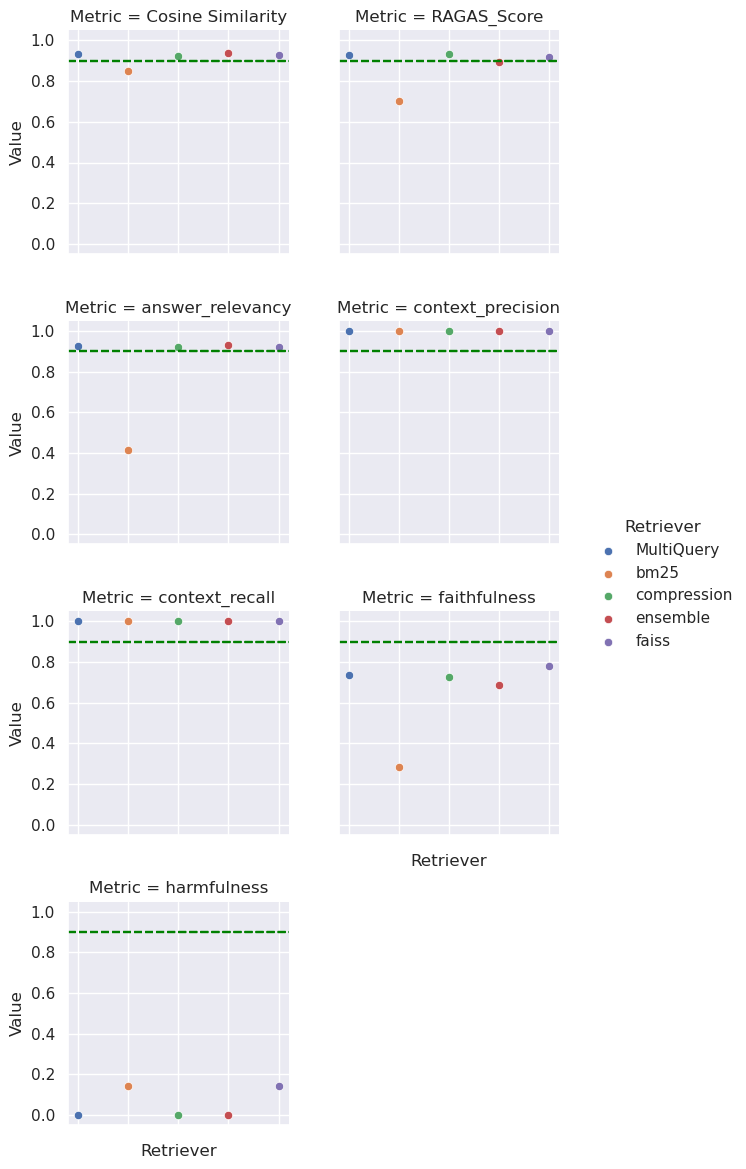

In [111]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(30,35)})
#define grid with two plots per row
g = sns.FacetGrid(data=df_metrics_by_retriver, col='Metric', col_wrap=2,hue='Retriever')
g.map(sns.scatterplot, 'Retriever','Value')
g.add_legend()
g.map(plt.axhline, y=0.9, ls='--', c='green')
g.set(xticklabels=[]) 


In [112]:
#Most retrievers showed good performance. Based on the relevancy, cosine similarity and RAGAS score FAISS, multiquery and compression showed best results
df_metrics_by_retriver.sort_values(by=['Metric','Value'],ascending=False)

,Retriever,Metric,Value
13,bm25,harmfulness,0.142857
34,faiss,harmfulness,0.142857
6,MultiQuery,harmfulness,0.000000
20,compression,harmfulness,0.000000
27,ensemble,harmfulness,0.000000
33,faiss,faithfulness,0.779592
5,MultiQuery,faithfulness,0.736364
19,compression,faithfulness,0.728571
26,ensemble,faithfulness,0.687912
12,bm25,faithfulness,0.285714
